In [1]:
BATCH = 25

### Cargar

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    optimizers,
    metrics,
)
from keras import backend as K
import cv2
from PIL import Image, ImageEnhance ,ImageFilter
from sklearn.model_selection import train_test_split
import os

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-11-01 22:19:23.712579: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-01 22:19:23.722565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-01 22:19:23.733117: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-01 22:19:23.736340: E external/local

In [3]:
import tensorflow as tf
import logging
import warnings
warnings.filterwarnings("ignore")

# Verificar dispositivos disponibles
if tf.test.gpu_device_name():
    print('GPU encontrada:', tf.test.gpu_device_name())
else:
    print("No se encontró GPU. Se utilizará la CPU.")

# Listar todas las GPU disponibles
gpus = tf.config.experimental.list_physical_devices('GPU')

# Configurar el crecimiento de memoria para cada GPU
if gpus:
    for gpu in gpus:
        print("Activada la asignacion de memoria gradual")
        tf.config.experimental.set_memory_growth(gpu, True)

GPU encontrada: /device:GPU:0
Activada la asignacion de memoria gradual


I0000 00:00:1730495964.802737   68393 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730495964.831329   68393 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730495964.831487   68393 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730495964.874610   68393 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

### Librerias

In [4]:
import sqlite3
import shutil
import pandas as pd

 # Comprobar si el archivo existe
if not os.path.exists('../datos/grabacion/base_datos_cod_augmented.db'):
    # Copiar el archivo
    shutil.copy('../datos/grabacion/base_datos_cod.db', '../datos/grabacion/base_datos_cod_augmented.db')
    print("Archivo copiado exitosamente..")
else:
    print("Archivo ya existe..")

# Conectar a la base de datos (crea el archivo si no existe)
conexion = sqlite3.connect("../datos/grabacion/base_datos_cod_augmented.db")

# Crear un cursor para interactuar con la base de datos
cursor = conexion.cursor()

Archivo ya existe..


In [5]:
cursor.execute("SELECT MAX(id) FROM videos_mapa")
ID = cursor.fetchone()[0]

if ID == None:
    ID = 0

ID

2939

In [6]:
CANTIDAD_VIDEOS = 5

cursor.execute("SELECT id as id_video, COUNT(*) AS cantidad FROM videos_mapa GROUP BY id HAVING COUNT(*) > "+str(CANTIDAD_VIDEOS)+"")
resultados = cursor.fetchall()

# Obtener los nombres de las columnas
columnas = [descripcion[0] for descripcion in cursor.description]

# Crear el DataFrame
df_ids = pd.DataFrame(resultados, columns=columnas)

# Utilizando .to_numpy()
ARRAY_ID = df_ids['id_video'].to_numpy()

In [7]:
# Dividir en entrenamiento y prueba (10% para prueba)
X_train_Mapa, X_test_Mapa = train_test_split(ARRAY_ID, test_size=0.1, random_state=42)
# Dividir entrenamiento en entrenamiento y validación (30% de 90% para validación)
X_train_Mapa, X_valid_Mapa = train_test_split(X_train_Mapa, test_size=0.3, random_state=42)

In [8]:
print("train ->"+str(len(X_train_Mapa)))
print("valid ->"+str(len(X_valid_Mapa)))
print("test ->"+str(len(X_test_Mapa)))

train ->1417
valid ->608
test ->225


In [9]:
def crear_dataframe(lista_ids):
    # Crear un DataFrame vacío para almacenar los resultados
    df_mapa = pd.DataFrame()
    df_pov = pd.DataFrame()

    for id in lista_ids:
        query = f"SELECT * FROM videos_mapa WHERE id == {id}"
        query_pov = f"SELECT * FROM videos_pov WHERE id == {id}"

        # Leer el resultado de la consulta y añadirlo al DataFrame
        df_temporal = pd.read_sql_query(query, conexion)
        df_temporal_pov = pd.read_sql_query(query_pov, conexion)

        # Concatenar al DataFrame principal
        df_mapa = pd.concat([df_mapa, df_temporal], ignore_index=True)
        df_pov = pd.concat([df_pov, df_temporal_pov], ignore_index=True)
    
    return df_mapa , df_pov

In [10]:
df_train_mapa , df_train_pov = crear_dataframe(X_train_Mapa)
df_valid_mapa , df_valid_pov = crear_dataframe(X_valid_Mapa)
df_test_mapa , df_test_pov = crear_dataframe(X_test_Mapa)
conexion.close()

In [11]:
import ast

def preprocesado_df(df):
    # Convertir la columna de tipo object a listas de enteros
    df['etiqueta'] = df['etiqueta'].apply(ast.literal_eval)
    # Eliminamos las filas donde 'mouse_final' sea igual a [0, 4]
    filtro = df['etiqueta'].apply(lambda x: x[1] == 4)
    df = df[~filtro]
    # Crear un filtro booleano para las filas que cumplen la condición
    condicion = df['etiqueta'].apply(lambda x: x[1] == 2)
    # Juntamos las pulsaciones y tecla en una columna
    #x_positions_2 = df['etiqueta'].apply(lambda x: str(x[0])+str(x[1]))
    x_positions_2 = df['etiqueta'].apply(lambda x: str(x[1]))
    df['etiqueta'] = x_positions_2
    # Modificar solo las filas que cumplen con la condición
    #df.loc[condicion, 'etiqueta'] = df.loc[condicion, 'etiqueta'].apply(lambda x: "12")
    return df

In [12]:
df_train_mapa = preprocesado_df(df_train_mapa)
df_valid_mapa = preprocesado_df(df_valid_mapa)
df_test_mapa = preprocesado_df(df_test_mapa)

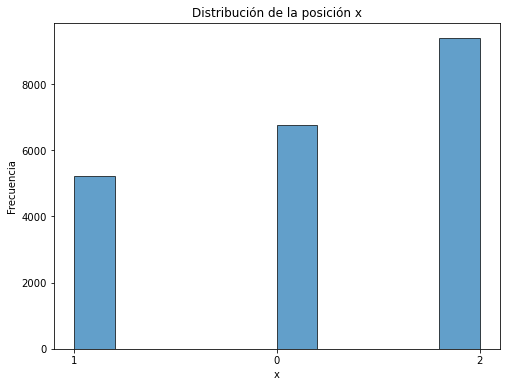

In [13]:
# Extraer la primera posición sin modificar el DataFrame
x_positions = df_train_mapa['etiqueta'].apply(lambda x: x[0])

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(8, 6))

# Crear el histograma
ax.hist(x_positions, bins=10, edgecolor='black', alpha=0.7)

# Agregar el título y las etiquetas de los ejes
ax.set_title('Distribución de la posición x')
ax.set_xlabel('x')
ax.set_ylabel('Frecuencia')

# Mostrar la figura
plt.show()

In [14]:
from sklearn.utils import class_weight

def aplicar_one_hot_balanceo(df,columa):
    # Crear un DataFrame con las columnas de one-hot encoding
    one_hot_df = pd.get_dummies(df[columa], prefix='label')

    # Unir el DataFrame original con el DataFrame de one-hot encoding
    df = pd.concat([df, one_hot_df], axis=1)

    # Balanceamos los pesos para el entrenamiento
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(df[columa]),
        y=df[columa]
    )

    # Crear un diccionario de pesos para las clases
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    #Eliminamos la columna original
    df = df.drop(columa, axis=1)
    return df , class_weight_dict

In [15]:
df_train_mapa , pesos_train = aplicar_one_hot_balanceo(df_train_mapa,"etiqueta")
df_valid_mapa , pesos_valid = aplicar_one_hot_balanceo(df_valid_mapa,"etiqueta")
df_test_mapa , pesos_test= aplicar_one_hot_balanceo(df_test_mapa,"etiqueta")

In [16]:
ETIQUETAS = np.array(df_train_mapa.filter(like='label').columns.tolist())

### Preprocesamiento

In [17]:
from keras.utils import Sequence

class ImageDataGenerator(Sequence):
    def __init__(self, df , sequence_length ,image_height , image_width , batch_size, filtro, **kwargs):
        self.df = df
        self.image_sequence_length = sequence_length
        self.image_height = image_height
        self.image_width = image_width
        self.batch_size = batch_size
        self.POV = filtro
        super().__init__(**kwargs)  # Llamada al constructor de la clase base

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def cargar_todo(self,fin_df):
        batch_df = self.df.iloc[0:fin_df]     #Obtenemos un lote del df

        X_batch = np.zeros((len(batch_df), self.image_sequence_length ,self.image_height, self.image_width, 3))  # Inicializar matriz para las imágenes
        #y_batch = batch_df[['izquieda', 'derecha', 'delante']].values
        y_batch = np.array(batch_df['mouse_final'].tolist())

        for i, (_, row) in enumerate(batch_df.iterrows()):
            frames = []
            for j in range(self.image_sequence_length):
                imagen = Image.open("../" + row.iloc[j])    # Obtener la ruta de la imagen
                imagen = Image.fromarray(np.array(imagen)).filter(ImageFilter.SHARPEN)  #Aplicamos Filtro SHARPEN
                imagen = np.array(imagen) / 255.0           # Normalizar la imagen

                frames.append(imagen)                  #Juntamos frames en lista
            video = np.stack(frames, axis=0)           # Convertir lista de frames en un video np
            X_batch[i] = video

        return X_batch, y_batch

    def __getitem__(self, index):
        inicio_lote = index * self.batch_size
        final_lote = (index + 1) * self.batch_size

        batch_df = self.df.iloc[inicio_lote:final_lote]     #Obtenemos un lote del df

        X_batch = np.zeros((len(batch_df), self.image_sequence_length ,self.image_height, self.image_width, 3))  # Inicializar matriz para las imágenes
        # Obtener y_batch después del one-hot encoding
        #y_batch = batch_df[['izquieda', 'derecha','delante']].values
        #y_batch = np.array(batch_df['mouse_final'].tolist())

        # Filtrar las columnas que comienzan con 'label'
        y_batch = batch_df.filter(like='label').values

        for i, (_, row) in enumerate(batch_df.iterrows()):
            frames = []
            for j in range(self.image_sequence_length):
                imagen = Image.open("../" + row.iloc[j+2])    # Obtener la ruta de la imagen
                ancho, alto = imagen.size

                if self.POV == True :
                    imagen = imagen.rotate(2.5, expand=True)
                    # Recorta la imagen (izquierda, superior, derecha, inferior)
                    imagen = imagen.crop((5, 12, ancho - 35, alto-25))
                    imagen = ImageEnhance.Sharpness(imagen)
                    imagen = imagen.enhance(7)  # Aumento de contraste

                imagen = np.array(imagen) / 255.0           # Normalizar la imagen

                frames.append(imagen)                  #Juntamos frames en lista
            video = np.stack(frames, axis=0)           # Convertir lista de frames en un video np
            X_batch[i] = video

        return X_batch, y_batch

def comprobar_contenido(X_train , Y_train , num_video):

    fig, axs = plt.subplots(1, 5, figsize=(5 * 2, 1 * 2))

    for i in range(5):
        axs[i].imshow(X_train[num_video][i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()
    print(Y_train[num_video])
    return Y_train[num_video]


class ImageDataGeneratorVAR(ImageDataGenerator):
    def __init__(self, df , sequence_length ,image_height , image_width , batch_size, filtro,autoencoder,encoder = None,**kwargs):
        self.autoencoder = autoencoder
        self.encoder_entrenado = encoder
        super().__init__(df, sequence_length, image_height, image_width, batch_size, filtro, **kwargs)

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def cargar_todo(self,fin_df):
        batch_df = self.df.iloc[0:fin_df]     #Obtenemos un lote del df

        X_batch = np.zeros((len(batch_df), self.image_sequence_length ,self.image_height, self.image_width, 3))  # Inicializar matriz para las imágenes
        #y_batch = batch_df[['izquieda', 'derecha', 'delante']].values
        y_batch = np.array(batch_df['mouse_final'].tolist())

        for i, (_, row) in enumerate(batch_df.iterrows()):
            frames = []
            for j in range(self.image_sequence_length):
                imagen = Image.open("../" + row.iloc[j])    # Obtener la ruta de la imagen
                imagen = Image.fromarray(np.array(imagen)).filter(ImageFilter.SHARPEN)  #Aplicamos Filtro SHARPEN
                imagen = np.array(imagen) / 255.0           # Normalizar la imagen

                frames.append(imagen)                  #Juntamos frames en lista
            video = np.stack(frames, axis=0)           # Convertir lista de frames en un video np
            X_batch[i] = video

        return X_batch, y_batch
    
    def __concatenar_imgs_individual__(self,X_batch):
        batch_independiente = []
        for i in range(X_batch.shape[0]):
            batch_independiente.append(X_batch[i][4])
        return np.array(batch_independiente)

    def __getitem__(self, index):
        inicio_lote = index * self.batch_size
        final_lote = (index + 1) * self.batch_size

        batch_df = self.df.iloc[inicio_lote:final_lote]     #Obtenemos un lote del df

        # Inicializar matriz para las imágenes
        #X_batch = np.zeros((len(batch_df), self.image_sequence_length ,self.image_height, self.image_width, 3))
        X_batch = np.zeros((len(batch_df), self.image_sequence_length, 120, 120, 3))  # Ajustar a 100x100
        
        # Filtrar las columnas que comienzan con 'label'
        y_batch = batch_df.filter(like='label').values

        for i, (_, row) in enumerate(batch_df.iterrows()):
            frames = []
            for j in range(self.image_sequence_length):
                imagen = Image.open("../" + row.iloc[j+2])    # Obtener la ruta de la imagen
                ancho, alto = imagen.size

                if self.POV == True :
                    imagen = imagen.rotate(2.5, expand=True)
                    # Recorta la imagen (izquierda, superior, derecha, inferior)
                    imagen = imagen.crop((5, 12, ancho - 35, alto-25))
                    imagen = ImageEnhance.Sharpness(imagen)
                    imagen = imagen.enhance(7)  # Aumento de contraste

                imagen = imagen.resize((120, 120))          #(100, 100)
                imagen = np.array(imagen).astype("float32")  / 255.0           # Normalizar la imagen

                frames.append(imagen)                  #Juntamos frames en lista
            video = np.stack(frames, axis=0)           # Convertir lista de frames en un video np
            X_batch[i] = video
        
        #Para autoencoder
        if self.autoencoder == True:
            return self.__concatenar_imgs_individual__(X_batch)
        else : 
            return self.__concatenar_imgs_individual__(X_batch), y_batch

def comprobar_contenido(X_train , num_video):

    fig, axs = plt.subplots(1, 5, figsize=(5 * 2, 1 * 2))

    for i in range(5):
        axs[i].imshow(X_train[num_video][i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

In [18]:
encoder_entrenado = None
autoencoder = True
# Generador Mapa
altura_img_mini = 188
anchura_img_mini = 260
batch_size = BATCH 

# Generadores para autoencoder
train_generator_Mapa = ImageDataGeneratorVAR(df_train_mapa, sequence_length=5, image_height=altura_img_mini, image_width=anchura_img_mini, batch_size=batch_size ,filtro =True , autoencoder = autoencoder , encoder= encoder_entrenado)
test_generator_Mapa = ImageDataGeneratorVAR(df_test_mapa, sequence_length=5, image_height=altura_img_mini, image_width=anchura_img_mini, batch_size=batch_size ,filtro =True, autoencoder = autoencoder, encoder= encoder_entrenado)
valid_generator_Mapa = ImageDataGeneratorVAR(df_valid_mapa, sequence_length=5, image_height=altura_img_mini, image_width=anchura_img_mini, batch_size=batch_size ,filtro =True, autoencoder = autoencoder, encoder= encoder_entrenado)

In [33]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, train_generator):
        """Step run during training."""
        for step in range(len(train_generator)):
            data = train_generator[step]
            with tf.GradientTape() as tape:
                #TensorFlow's Gradient Tape helps calculate gradients during a forward pass.
                #To use it, we need wrap the code that performs the operations you want to differentiate within a tf.GradientTape() context.
                #After recording the operations, we can compute the gradient of the loss function concerning certain variables using tape.gradient().
                #These gradients are then used to update the variables with the optimizer.

                z_mean, z_log_var, reconstruction = self(data)
                beta = 500
                reconstruction_loss = tf.reduce_mean(
                    beta
                    * losses.binary_crossentropy(
                        data, reconstruction, axis=(1, 2, 3)
                    )
                )
                kl_loss = tf.reduce_mean(
                    tf.reduce_sum(
                        -0.5
                        * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                        axis=1,
                    )
                )
                total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        beta = 500
        reconstruction_loss = tf.reduce_mean(
            beta
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [34]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten ,Conv2DTranspose,Reshape,Dense,BatchNormalization,Dropout
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K

#Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        # Cambiar K.random_normal a tf.random.normal
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def compute_output_shape(self, input_shape):
        # La salida de la capa tiene la misma forma que z_mean y z_log_var
        return input_shape[0]

def get_encoder_primero(input_shape,embed_dim):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.01))(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.01))(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.01))(x)
    x = MaxPooling2D((2, 2))(x)
    encoded = Flatten()(x)

    z_mean = layers.Dense(embed_dim, name="z_mean")(encoded)
    z_log_var = layers.Dense(embed_dim, name="z_log_var")(encoded)

    z = Sampling()([z_mean, z_log_var])

    Encoder_primero = tf.keras.Model(inputs=inputs,outputs=[z_mean, z_log_var, z])
    return Encoder_primero ,encoded.shape

def get_decoder(input_shape):
    z = Input(shape=input_shape)
    x = Dense(28800 ,activation="relu",kernel_regularizer=l2(0.01))(z) 
    x = Reshape((15, 15, 128))(x)
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="relu",kernel_regularizer=l2(0.01))(x)
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same", activation="relu",kernel_regularizer=l2(0.01))(x)
    x = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding="same", activation="relu",kernel_regularizer=l2(0.01))(x)
    decoded_img = Conv2DTranspose(3, (2, 2), padding="same", activation="sigmoid")(x)

    Decoder = tf.keras.Model(inputs=z,outputs=[decoded_img])
    return Decoder

In [35]:
ESPACIO_LATENTE = 10
height = 120
width = 120
channels = 3
input_shape_pov = (height, width, channels)

encoder,flatten_layer = get_encoder_primero(input_shape_pov,ESPACIO_LATENTE)
dimension = []
dimension.append(ESPACIO_LATENTE + 0)
size_flatten_etiqueta = tuple(dimension)
decoder = get_decoder(size_flatten_etiqueta)

In [36]:
encoder.summary()
decoder.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 120, 120,  │        896 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 60, 60,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 60, 60,    │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 30, 30,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 30, 30,    │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 15, 15,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 28800)     │          0 │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 10)        │    288,010 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 10)        │    288,010 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_2          │ (None, 10)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 669,268 (2.55 MB)

 Trainable params: 669,268 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 28800)          │       316,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 30, 30, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 60, 60, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 120, 120, 16)   │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 120, 120, 3)    │           195 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 413,875 (1.58 MB)

 Trainable params: 413,875 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

### Final

In [37]:
vae = VAE(encoder, decoder)

In [ ]:
# Obtener un lote de prueba (imágenes y etiquetas)
X_batch = test_generator_Mapa.__getitem__(0)  # Obtenemos un lote de test

for i in range(0,batch_size):
    plt.imshow(X_batch[i])
    plt.axis('off')  # Opcional: oculta los ejes
    plt.show()

In [39]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


vae.fit(
    train_generator_Mapa,
    epochs=10,
    batch_size=BATCH,
    validation_data=(test_generator_Mapa, test_generator_Mapa),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/10


2024-11-01 22:38:29.438968: W tensorflow/core/framework/op_kernel.cc:1828] INVALID_ARGUMENT: TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float64,), but the yielded element was [[[[0.20392157 0.17254902 0.18431373]
   [0.24705882 0.23529412 0.23921569]
   [0.20392157 0.20784314 0.20392157]
   ...
   [0.99607843 0.98823529 0.98039216]
   [0.98823529 0.98039216 0.97254902]
   [0.96862745 0.95294118 0.93725491]]

  [[0.38431373 0.32549021 0.34509805]
   [0.34509805 0.33725491 0.33725491]
   [0.34117648 0.35686275 0.34901962]
   ...
   [0.78823531 0.78039217 0.7764706 ]
   [0.94117647 0.94117647 0.93725491]
   [0.98039216 0.97647059 0.96862745]]

  [[0.3137255  0.25490198 0.27450982]
   [0.15686275 0.15686275 0.15686275]
   [0.26666668 0.28235295 0.27058825]
   ...
   [0.20392157 0.18431373 0.20392157]
   [0.70980394 0.7019608  0.70980394]
   [1.         1.         1.        ]]

  ...

  [[0.         0.         0.      

InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float64,), but the yielded element was [[[[0.20392157 0.17254902 0.18431373]
   [0.24705882 0.23529412 0.23921569]
   [0.20392157 0.20784314 0.20392157]
   ...
   [0.99607843 0.98823529 0.98039216]
   [0.98823529 0.98039216 0.97254902]
   [0.96862745 0.95294118 0.93725491]]

  [[0.38431373 0.32549021 0.34509805]
   [0.34509805 0.33725491 0.33725491]
   [0.34117648 0.35686275 0.34901962]
   ...
   [0.78823531 0.78039217 0.7764706 ]
   [0.94117647 0.94117647 0.93725491]
   [0.98039216 0.97647059 0.96862745]]

  [[0.3137255  0.25490198 0.27450982]
   [0.15686275 0.15686275 0.15686275]
   [0.26666668 0.28235295 0.27058825]
   ...
   [0.20392157 0.18431373 0.20392157]
   [0.70980394 0.7019608  0.70980394]
   [1.         1.         1.        ]]

  ...

  [[0.         0.         0.        ]
   [0.31764707 0.34509805 0.42352942]
   [0.23529412 0.25882354 0.33725491]
   ...
   [0.31764707 0.31764707 0.35686275]
   [0.27450982 0.29411766 0.30980393]
   [0.3137255  0.32941177 0.36470589]]

  [[0.         0.         0.        ]
   [0.34509805 0.37254903 0.42745098]
   [0.25490198 0.28235295 0.32549021]
   ...
   [0.31764707 0.32941177 0.35294119]
   [0.29803923 0.3137255  0.33725491]
   [0.30588236 0.30980393 0.34117648]]

  [[0.         0.         0.        ]
   [0.25490198 0.27843139 0.3137255 ]
   [0.29411766 0.32156864 0.36470589]
   ...
   [0.32156864 0.33333334 0.36470589]
   [0.29019609 0.30980393 0.35294119]
   [0.28627452 0.3019608  0.34509805]]]


 [[[0.10980392 0.13725491 0.18039216]
   [0.15294118 0.18431373 0.23529412]
   [0.15686275 0.16470589 0.20784314]
   ...
   [0.96862745 0.97647059 0.98823529]
   [0.90980393 0.9137255  0.92941177]
   [0.84705883 0.8509804  0.87450981]]

  [[0.2        0.24705882 0.32941177]
   [0.23529412 0.28235295 0.36470589]
   [0.23921569 0.25490198 0.31764707]
   ...
   [0.78431374 0.7764706  0.78823531]
   [0.94901961 0.94901961 0.95294118]
   [0.90980393 0.90588236 0.92156863]]

  [[0.15294118 0.18431373 0.24705882]
   [0.14901961 0.17254902 0.23529412]
   [0.16078432 0.16078432 0.20784314]
   ...
   [0.13725491 0.10980392 0.13333334]
   [0.66274512 0.65098041 0.66666669]
   [0.94117647 0.94509804 0.95686275]]

  ...

  [[0.         0.         0.        ]
   [0.34901962 0.43529412 0.50588238]
   [0.32549021 0.38039216 0.45882353]
   ...
   [0.38039216 0.36078432 0.43137255]
   [0.33725491 0.3019608  0.3882353 ]
   [0.38039216 0.32941177 0.42352942]]

  [[0.         0.         0.        ]
   [0.38039216 0.44705883 0.52156866]
   [0.34509805 0.41176471 0.48235294]
   ...
   [0.38039216 0.33333334 0.42352942]
   [0.39607844 0.33725491 0.43137255]
   [0.39607844 0.33725491 0.42745098]]

  [[0.         0.         0.        ]
   [0.25882354 0.29803923 0.34509805]
   [0.32549021 0.38431373 0.44705883]
   ...
   [0.40392157 0.34117648 0.44313726]
   [0.39215687 0.32941177 0.42352942]
   [0.3882353  0.32941177 0.41960785]]]


 [[[0.23137255 0.28235295 0.3019608 ]
   [0.3137255  0.36862746 0.40000001]
   [0.31764707 0.36470589 0.40000001]
   ...
   [0.47450981 0.59607846 0.70588237]
   [0.36862746 0.49019608 0.60784316]
   [0.25490198 0.38039216 0.49019608]]

  [[0.41568628 0.50588238 0.56470591]
   [0.48627451 0.57254905 0.64313728]
   [0.48235294 0.56078434 0.63137257]
   ...
   [0.40000001 0.48235294 0.59607846]
   [0.45882353 0.54901963 0.66666669]
   [0.32941177 0.43529412 0.53725493]]

  [[0.32156864 0.38039216 0.43921569]
   [0.3019608  0.36470589 0.42352942]
   [0.29803923 0.35294119 0.41568628]
   ...
   [0.00784314 0.03137255 0.14509805]
   [0.24313726 0.29803923 0.42352942]
   [0.3764706  0.46666667 0.58039218]]

  ...

  [[0.         0.         0.        ]
   [0.49019608 0.35686275 0.48235294]
   [0.3882353  0.27450982 0.3764706 ]
   ...
   [0.11764706 0.19607843 0.24313726]
   [0.07450981 0.14509805 0.19215687]
   [0.10588235 0.16470589 0.22352941]]

  [[0.         0.         0.        ]
   [0.50588238 0.38039216 0.49803922]
   [0.36862746 0.25098041 0.36078432]
   ...
   [0.09411765 0.15686275 0.21960784]
   [0.10196079 0.16078432 0.22745098]
   [0.10588235 0.16862746 0.22352941]]

  [[0.         0.         0.        ]
   [0.36078432 0.29411766 0.36470589]
   [0.43921569 0.33725491 0.44313726]
   ...
   [0.10980392 0.17647059 0.23921569]
   [0.10980392 0.17647059 0.23921569]
   [0.10980392 0.17647059 0.23921569]]]


 ...


 [[[0.21568628 0.17254902 0.2       ]
   [0.32156864 0.23529412 0.24313726]
   [0.36862746 0.22352941 0.24705882]
   ...
   [0.85882354 0.78823531 0.8392157 ]
   [0.79215688 0.69803923 0.73725492]
   [0.6901961  0.57647061 0.6156863 ]]

  [[0.39215687 0.32549021 0.36862746]
   [0.47450981 0.35294119 0.34901962]
   [0.65882355 0.35686275 0.40000001]
   ...
   [0.64705884 0.63529414 0.71372551]
   [0.80784315 0.76078433 0.81960785]
   [0.73333335 0.63921571 0.68235296]]

  [[0.29411766 0.24705882 0.27843139]
   [0.28235295 0.21960784 0.20784314]
   [0.47450981 0.23137255 0.25098041]
   ...
   [0.05882353 0.09803922 0.23137255]
   [0.45490196 0.43921569 0.53333336]
   [0.73333335 0.66666669 0.73725492]]

  ...

  [[0.         0.         0.        ]
   [0.36470589 0.27843139 0.47058824]
   [0.33725491 0.23137255 0.41568628]
   ...
   [0.00392157 0.3137255  0.65490198]
   [0.         0.26666668 0.59607846]
   [0.         0.30588236 0.64705884]]

  [[0.         0.         0.        ]
   [0.35294119 0.30980393 0.51372552]
   [0.30588236 0.23529412 0.45490196]
   ...
   [0.00392157 0.26274511 0.6156863 ]
   [0.01960784 0.25882354 0.61176473]
   [0.00784314 0.27450982 0.63137257]]

  [[0.         0.         0.        ]
   [0.24705882 0.28235295 0.39215687]
   [0.30980393 0.35294119 0.52941179]
   ...
   [0.02745098 0.25882354 0.61960787]
   [0.03921569 0.24705882 0.60000002]
   [0.03137255 0.25490198 0.60784316]]]


 [[[0.30588236 0.29803923 0.30980393]
   [0.40000001 0.40000001 0.39607844]
   [0.40000001 0.40000001 0.40000001]
   ...
   [0.81568629 0.98039216 1.        ]
   [0.73333335 0.92941177 1.        ]
   [0.60784316 0.8509804  0.98823529]]

  [[0.58039218 0.5411765  0.60784316]
   [0.64313728 0.63137257 0.68627453]
   [0.59215689 0.58823532 0.627451  ]
   ...
   [0.64313728 0.80784315 0.94509804]
   [0.78431374 0.9254902  0.98039216]
   [0.67843139 0.89019608 0.99215686]]

  [[0.4509804  0.39215687 0.47058824]
   [0.44705883 0.40000001 0.47843137]
   [0.42745098 0.38431373 0.44313726]
   ...
   [0.03137255 0.20392157 0.3764706 ]
   [0.45882353 0.63529414 0.7764706 ]
   [0.74901962 0.9254902  1.        ]]

  ...

  [[0.         0.         0.        ]
   [0.1882353  0.26274511 0.43529412]
   [0.16862746 0.22745098 0.38431373]
   ...
   [0.16078432 0.17647059 0.10980392]
   [0.1254902  0.12941177 0.06666667]
   [0.15294118 0.15686275 0.09411765]]

  [[0.         0.         0.        ]
   [0.21176471 0.32549021 0.49803922]
   [0.13725491 0.24313726 0.40000001]
   ...
   [0.16470589 0.17254902 0.12941177]
   [0.17647059 0.17254902 0.1254902 ]
   [0.18039216 0.16862746 0.12156863]]

  [[0.         0.         0.        ]
   [0.15686275 0.26666668 0.36862746]
   [0.18039216 0.32549021 0.4627451 ]
   ...
   [0.19215687 0.18431373 0.12941177]
   [0.18039216 0.16470589 0.1254902 ]
   [0.18039216 0.16470589 0.12156863]]]


 [[[0.21568628 0.22352941 0.30980393]
   [0.30588236 0.35294119 0.39607844]
   [0.28235295 0.38431373 0.40000001]
   ...
   [0.66274512 0.67450982 0.64705884]
   [0.58039218 0.58039218 0.53725493]
   [0.47450981 0.47843137 0.41960785]]

  [[0.42745098 0.43529412 0.62352943]
   [0.47058824 0.54901963 0.67843139]
   [0.40000001 0.56862748 0.63529414]
   ...
   [0.52549022 0.57647061 0.57647061]
   [0.66666669 0.6901961  0.66274512]
   [0.54509807 0.54901963 0.50588238]]

  [[0.39607844 0.41960785 0.57254905]
   [0.3137255  0.38431373 0.50980395]
   [0.27450982 0.38431373 0.4627451 ]
   ...
   [0.01960784 0.08627451 0.11764706]
   [0.32549021 0.36078432 0.35294119]
   [0.53725493 0.5411765  0.50588238]]

  ...

  [[0.         0.         0.        ]
   [0.22745098 0 [Op:__inference_one_step_on_iterator_8525]

0784314]
   ...
   [0.96862745 0.97647059 0.98823529]
   [0.90980393 0.9137255  0.92941177]
   [0.84705883 0.8509804  0.87450981]]

  [[0.2        0.24705882 0.32941177]
   [0.23529412 0.28235295 0.36470589]
   [0.23921569 0.25490198 0.31764707]
   ...
   [0.78431374 0.7764706  0.78823531]
   [0.94901961 0.94901961 0.95294118]
   [0.90980393 0.90588236 0.92156863]]

  [[0.15294118 0.18431373 0.24705882]
   [0.14901961 0.17254902 0.23529412]
   [0.16078432 0.16078432 0.20784314]
   ...
   [0.13725491 0.10980392 0.13333334]
   [0.66274512 0.65098041 0.66666669]
   [0.94117647 0.94509804 0.95686275]]

  ...

  [[0.         0.         0.        ]
   [0.34901962 0.43529412 0.50588238]
   [0.32549021 0.38039216 0.45882353]
   ...
   [0.38039216 0.36078432 0.43137255]
   [0.33725491 0.3019608  0.3882353 ]
   [0.38039216 0.32941177 0.42352942]]

  [[0.         0.         0.        ]
   [0.38039216 0.44705883 0.52156866]
   [0.34509805 0.41176471 0.48235294]
   ...
   [0.38039216 0.33333334 0.4

0.25882354 0.61176473]
   [0.00784314 0.27450982 0.63137257]]

  [[0.         0.         0.        ]
   [0.24705882 0.28235295 0.39215687]
   [0.30980393 0.35294119 0.52941179]
   ...
   [0.02745098 0.25882354 0.61960787]
   [0.03921569 0.24705882 0.60000002]
   [0.03137255 0.25490198 0.60784316]]]


 [[[0.30588236 0.29803923 0.30980393]
   [0.40000001 0.40000001 0.39607844]
   [0.40000001 0.40000001 0.40000001]
   ...
   [0.81568629 0.98039216 1.        ]
   [0.73333335 0.92941177 1.        ]
   [0.60784316 0.8509804  0.98823529]]

  [[0.58039218 0.5411765  0.60784316]
   [0.64313728 0.63137257 0.68627453]
   [0.59215689 0.58823532 0.627451  ]
   ...
   [0.64313728 0.80784315 0.94509804]
   [0.78431374 0.9254902  0.98039216]
   [0.67843139 0.89019608 0.99215686]]

  [[0.4509804  0.39215687 0.47058824]
   [0.44705883 0.40000001 0.47843137]
   [0.42745098 0.38431373 0.44313726]
   ...
   [0.03137255 0.20392157 0.3764706 ]
   [0.45882353 0.63529414 0.7764706 ]
   [0.74901962 0.9254902  1